# ***Tarea 8. Gradient Boosting***
### Luis Eduardo Jiménez del Muro - 11/04/2025
---

# *Paqueterías*

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'lightgray'

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# *Funciones*

In [2]:
"""
Gráfica de Calibración
--------------------------------------------------------------------------------------------------------
"""
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    # Gráfica
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=4, lw=2)
    plt.title(f'Calibración del modelo \n\n$R²={r2:.4f}$', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--')
    plt.legend(fontsize=12)
    plt.show()


"""
Loss Plot
--------------------------------------------------------------------------------------------------------
"""
def loss_plot(train_loss, test_loss):
    plt.plot(train_loss, label='Train', c='cadetblue')
    plt.plot(test_loss, label='Test', c='red')
    plt.title('Loss', fontweight='bold', fontsize=16)
    plt.xlabel('Iteraciones', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.grid(alpha=0.5, ls='--')
    plt.legend(fontsize=12)
    plt.show()

"""
Importance Plot
--------------------------------------------------------------------------------------------------------
"""
def importance_plot(features, importance, type, n_features=10):
    df_importancia = pd.DataFrame({
        'features': features, 
        'importance': importance}).sort_values(by='importance', ascending=True)
    
    plt.barh(df_importancia['features'].tail(n_features), df_importancia['importance'].tail(n_features), 
             color='cadetblue', zorder=2, height=0.4)
    for i, v in enumerate(df_importancia['importance'].tail(n_features)):
        plt.text(v, i, f'{v:.2f}', color='black', fontsize=10)
    plt.title(f'Importancia {type}', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--', axis='x', zorder=0)
    plt.ylabel('Variable', fontsize=14)
    plt.xlabel('Importancia', fontsize=14)
    plt.show()


"""
Regresión Polinomial grado n
--------------------------------------------------------------------------------------------------------
"""
def polynomial(X, y, type, n, q=10):
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    poly_features = PolynomialFeatures(degree=n)
    X_poly = poly_features.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

    model = type.fit(X_train, y_train)
    predicciones_poly_2 = model.predict(X_test)
    calibracion(predicciones_poly_2, y_test, q)
    return model


"""
LightGBM
--------------------------------------------------------------------------------------------------------
"""
def lgbm(X, y, q=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LGBMRegressor(
        num_iterations=100_000,
        num_leaves=10,
        learning_rate=0.1,
        max_depth=6,
        lambda_l2=0.1,
        subsample=0.5,
        feature_fraction=0.8,
        verbosity=-1,
        metric='rmse'
    )

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
            callbacks=[early_stopping(50),
                        log_evaluation(100)])
    predicciones = model.predict(X_test)

    model.evals_result_.keys()
    train_loss = model.evals_result_['training']['rmse']
    test_loss = model.evals_result_['valid_1']['rmse']

    weight = model.booster_.feature_importance(importance_type='split')
    gain = model.booster_.feature_importance(importance_type='gain')

    calibracion(predicciones, y_test, q)
    loss_plot(train_loss, test_loss)
    importance_plot(X.columns, weight, '(Weight)')
    importance_plot(X.columns, gain, '(Gain)')
    return model


"""
CatBoost
--------------------------------------------------------------------------------------------------------
"""
def catboost(X, y, q=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

    for col in cat_cols:
        X_train[col] = X_train[col].astype(str).fillna('missing')
        X_test[col] = X_test[col].astype(str).fillna('missing')

    model = CatBoostRegressor(
        iterations=10_000,
        eval_metric='R2',
        depth=5,
        subsample=0.5,
        rsm=0.8,
        learning_rate=0.5,
        verbose=100,
        early_stopping_rounds=50
    )

    model.fit(X_train, y_train, cat_features=cat_cols, eval_set=[(X_train, y_train), (X_test, y_test)])
    predicciones = model.predict(X_test)

    train_loss = model.get_evals_result()['validation_0']['RMSE']
    test_loss = model.get_evals_result()['validation_1']['RMSE']

    importance = model.get_feature_importance(type='FeatureImportance')

    calibracion(predicciones, y_test, q)
    loss_plot(train_loss, test_loss)
    importance_plot(X.columns, importance, '')
    return model


"""
XGBoost
--------------------------------------------------------------------------------------------------------
"""
def xgboost(X, y, q=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = XGBRegressor(
        n_estimators=100_000,
        max_depth=10,
        learning_rate=0.1,
        reg_lambda=0.1,
        subsample=0.6,
        col_sample_by_tree=0.8,
        tree_method='hist'
    )

    # Haz fit, usa early stopping, verboso y evalset [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=100)
    predicciones = model.predict(X_test)

    train_loss = model.evals_result()['validation_0']['rmse']
    test_loss = model.evals_result()['validation_1']['rmse']

    weight = model.get_booster().get_score(importance_type='weight')
    gain = model.get_booster().get_score(importance_type='gain')

    calibracion(predicciones, y_test, q)
    loss_plot(train_loss, test_loss)
    importance_plot(weight.keys(), weight.values(), '(Weight)')
    importance_plot(gain.keys(), gain.values(), '(Gain)')
    return model

# *Preparar los datos*

In [3]:
df = pd.read_csv('data/Boston.csv')
df = df.drop(columns=['Unnamed: 0'])
df = pd.get_dummies(df, columns=['rad'])

df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,True,False,False,False,False,False,False,False,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,False,True,False,False,False,False,False,False,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,False,True,False,False,False,False,False,False,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,False,False,True,False,False,False,False,False,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,False,False,True,False,False,False,False,False,False


In [4]:
target = 'medv'

X = df.copy().drop(target, axis=1)
X_no_dummies = pd.read_csv('data/Boston.csv').drop(columns=['Unnamed: 0', target]) # Para catboost

y = df[target]

# *Regresión Lineal Grado 1 (para comparar con el modelo más sencillo)*

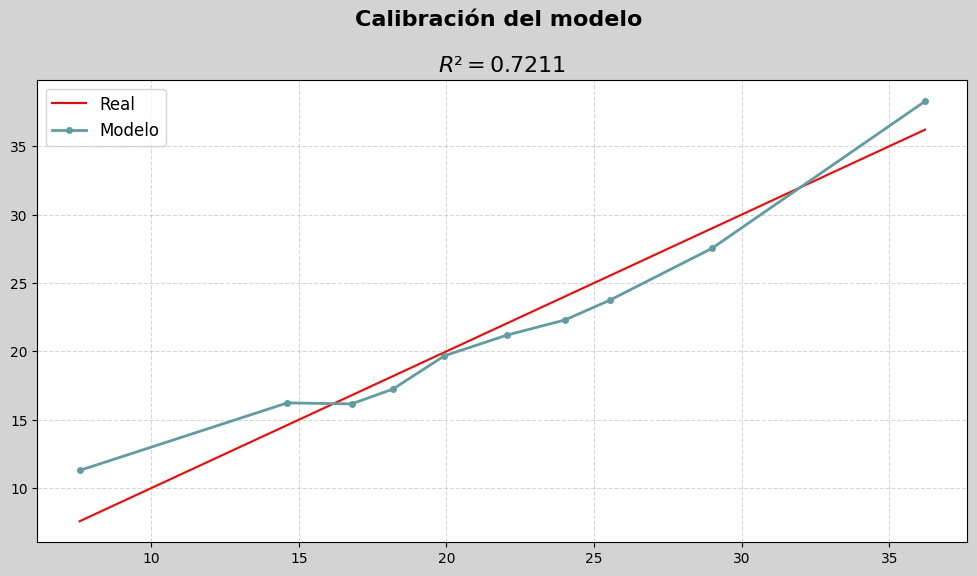

LinearRegression()

In [5]:
polynomial(X, y, LinearRegression(), 1, 10)

# *Light GBM*

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1.78161	valid_1's rmse: 3.32032
[200]	training's rmse: 1.22229	valid_1's rmse: 3.24876
[300]	training's rmse: 0.913703	valid_1's rmse: 3.22429
Early stopping, best iteration is:
[277]	training's rmse: 0.971781	valid_1's rmse: 3.20868


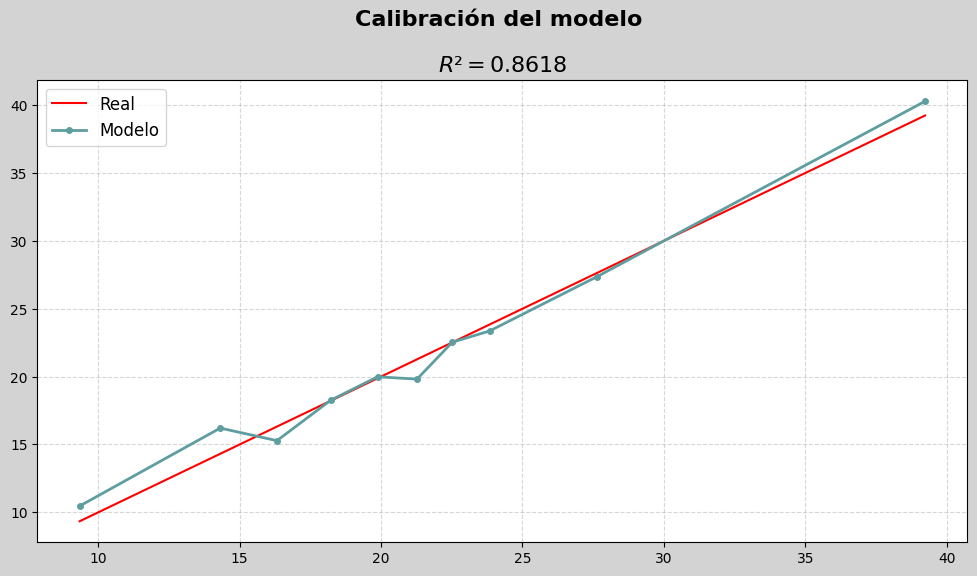

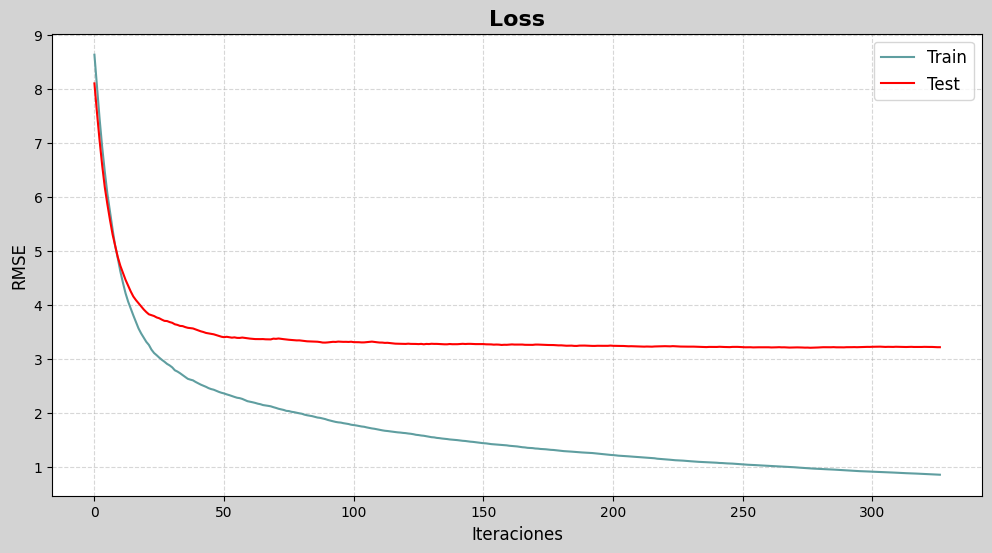

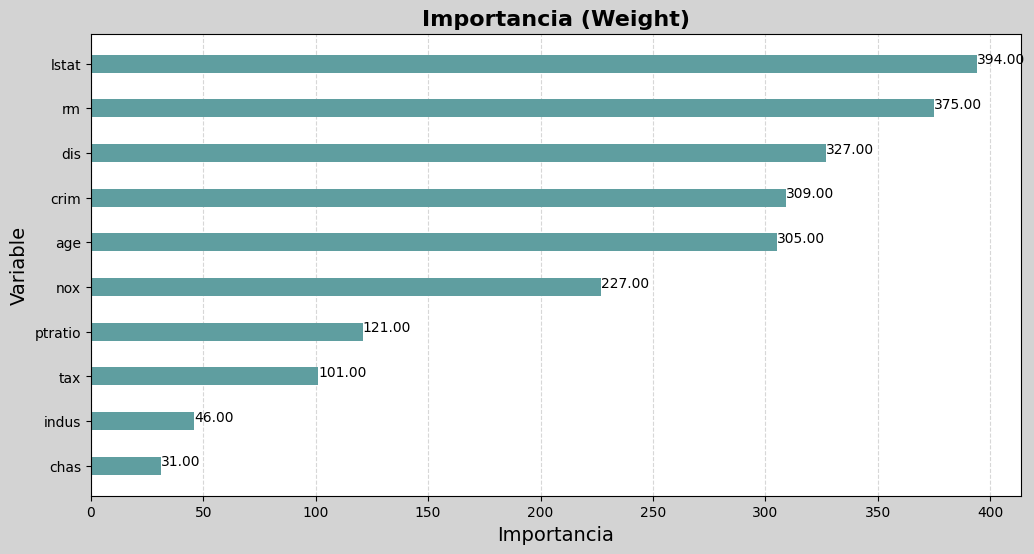

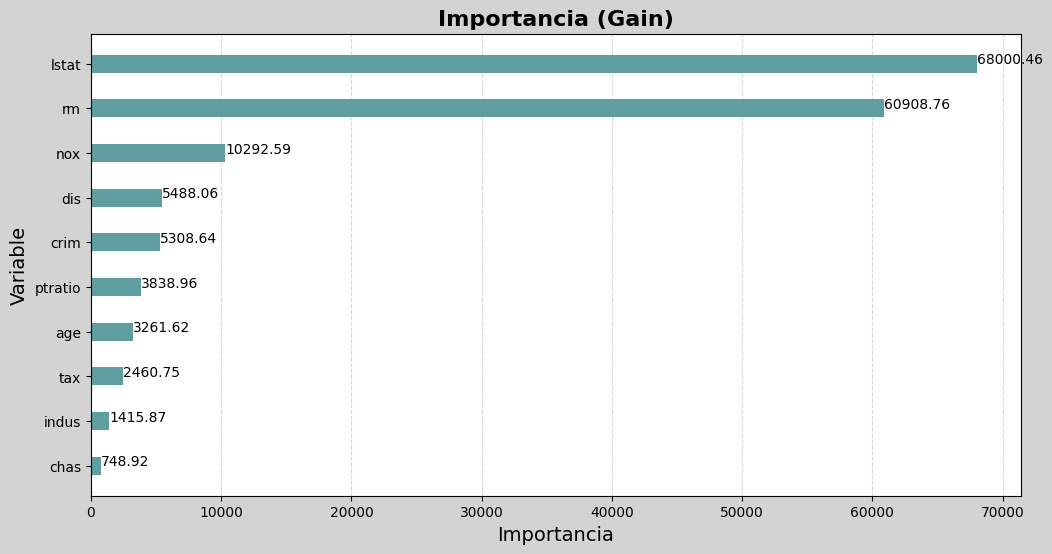

LGBMRegressor(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='rmse',
              num_iterations=100000, num_leaves=10, subsample=0.5,
              verbosity=-1)

In [6]:
lgbm(X, y, 10)

# *Catboost*

0:	learn: 0.4402559	test: 0.4402559	test1: 0.3500809	best: 0.3500809 (0)	total: 161ms	remaining: 26m 49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8717527749
bestIteration = 42

Shrink model to first 43 iterations.


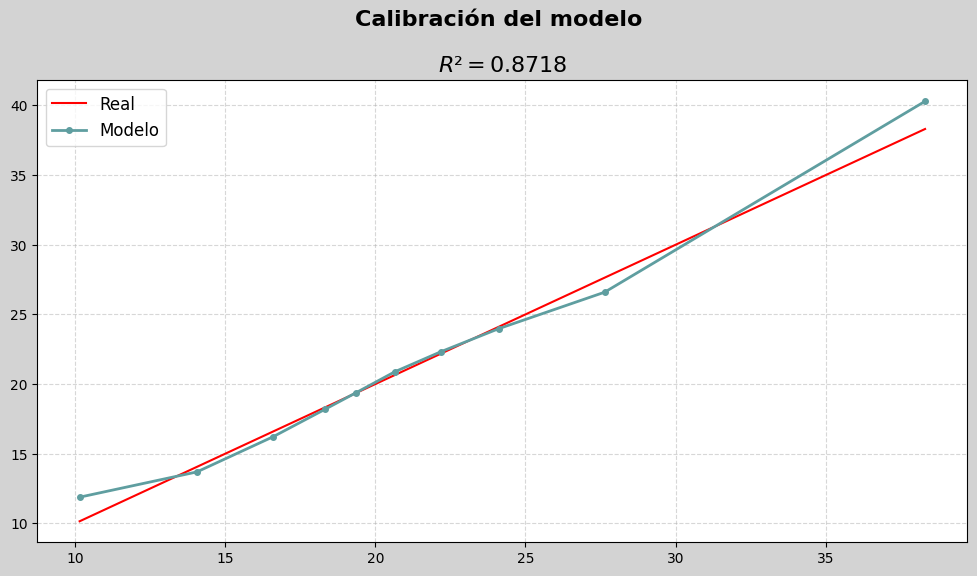

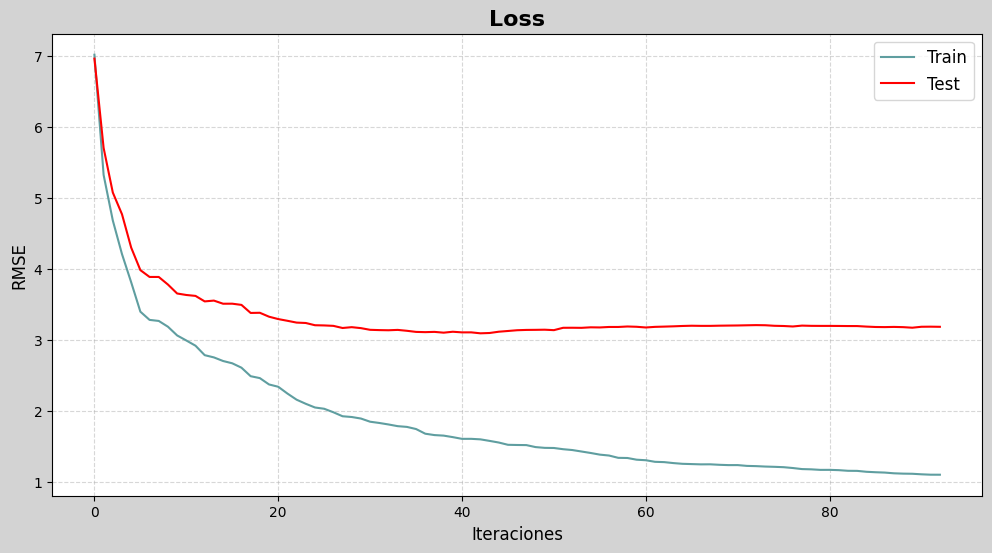

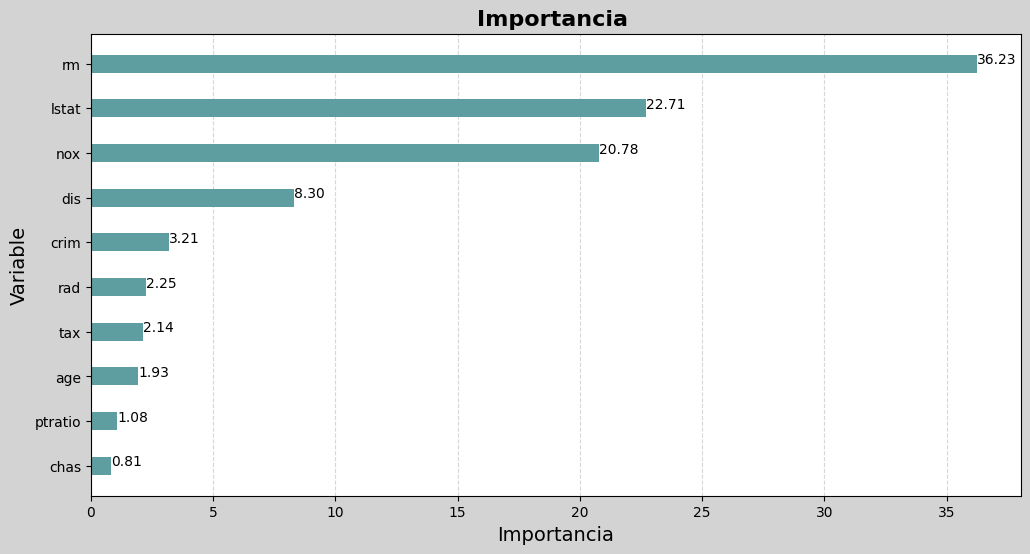

In [7]:
catboost(X_no_dummies, y, 10)

# *XGBoost*

[19:34:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "col_sample_by_tree" } are not used.

[0]	validation_0-rmse:22.02690	validation_1-rmse:20.42470
[100]	validation_0-rmse:0.08502	validation_1-rmse:2.63568
[131]	validation_0-rmse:0.03156	validation_1-rmse:2.63954


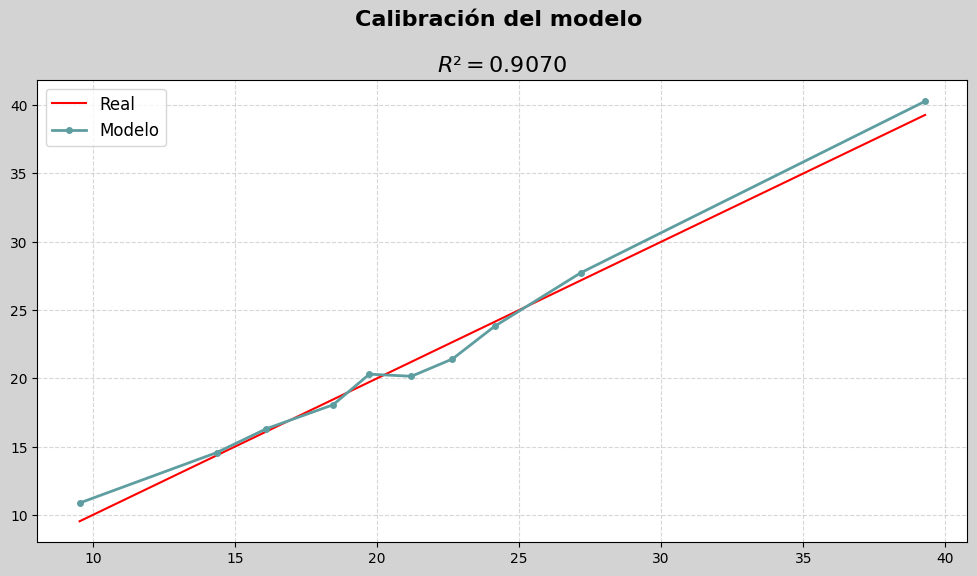

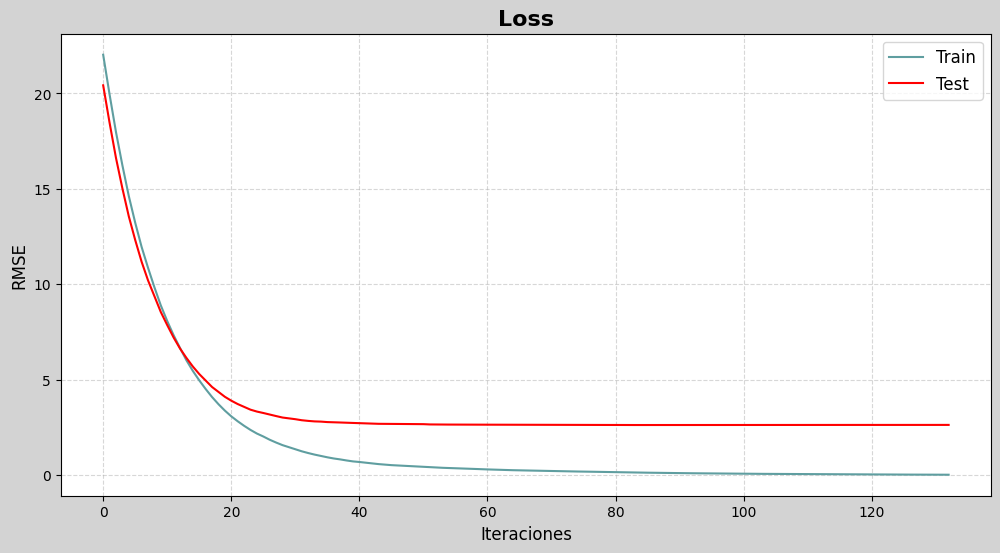

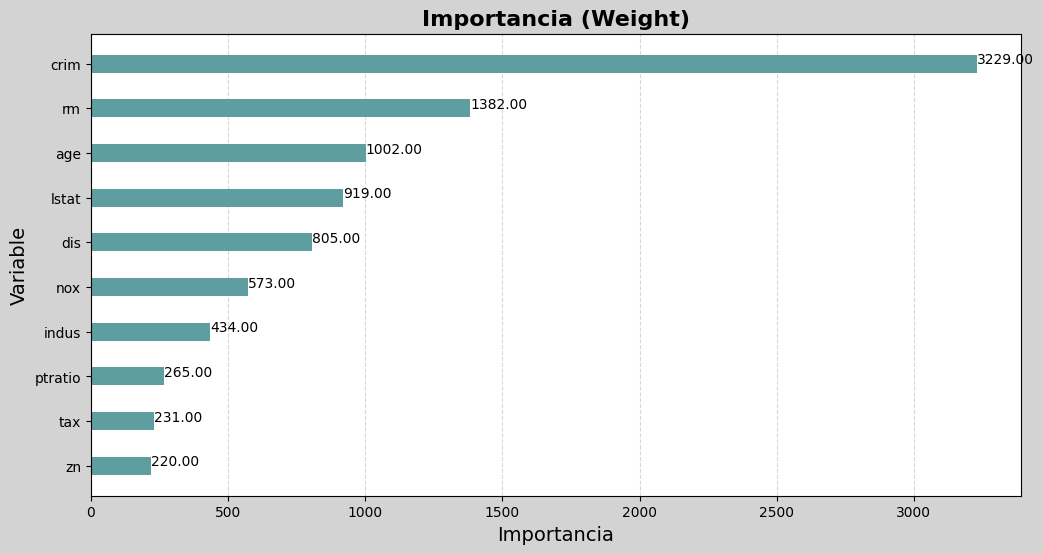

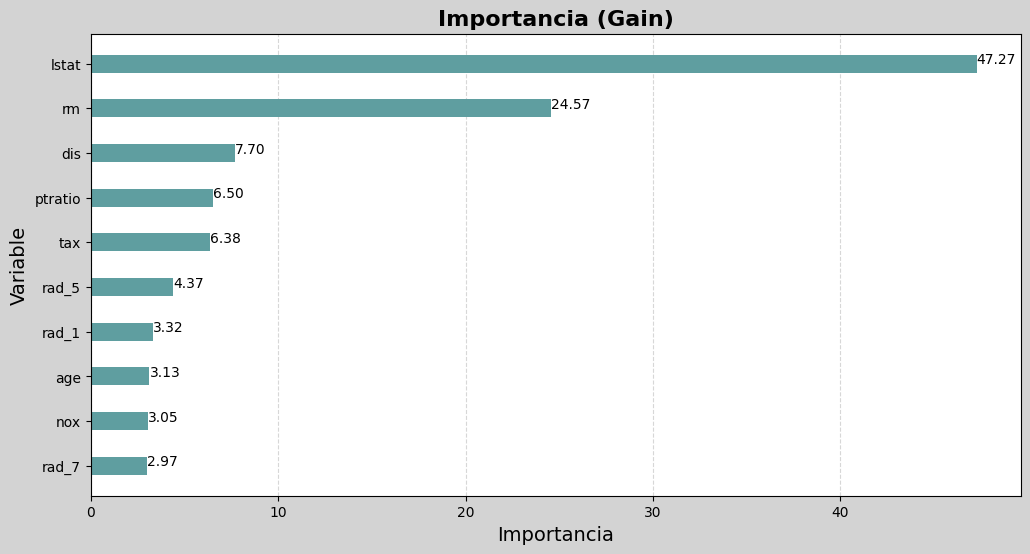

XGBRegressor(base_score=None, booster=None, callbacks=None,
             col_sample_by_tree=0.8, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [8]:
xgboost(X, y, 10)

# *Prueba de XGBoost con las variables utilizadas en el mejor modelo del examen*

In [10]:
# Variables modificadas
modified_features_df = pd.DataFrame()
modified_features_df['rm_2'] = df['rm']**2
modified_features_df['tax_2'] = df['tax']**2
modified_features_df['nox_2'] = df['nox']**2
modified_features_df['ptratio_2'] = df['ptratio']**2
modified_features_df['indus_2'] = df['indus']**2
modified_features_df['crim_2'] = df['crim']**2
modified_features_df['age_2'] = df['age']**2
modified_features_df['lstat_2'] = df['lstat']**2
modified_features_df['ln_dist'] = np.log(1+df['dis']) # +1 para evitar ln(0)

# Nuevas variables
new_features_df = pd.DataFrame()
new_features_df['crim_indus'] = df['crim'] / (1+df['indus']) # +1 para evitar divisiones entre cero
new_features_df['crim_lstat'] = df['crim'] / (1+df['lstat'])
new_features_df['rm_lstat'] = df['rm'] / (1+df['lstat'])
new_features_df['nox_indus'] = df['nox'] / (1+df['indus'])
new_features_df['nox_dis'] = df['nox'] / (1+df['dis'])
new_features_df['age_lstat'] = df['age'] / (1+df['lstat'])
new_features_df['tax_rm'] = df['tax'] / (1+df['rm'])
new_features_df['tax_lstat'] = df['tax'] / (1+df['lstat'])
new_features_df['ptratio_rm'] = df['ptratio'] / (1+df['rm'])
new_features_df['ptratio_nox'] = df['ptratio'] / (1+df['nox'])
new_features_df['ptratio_dis'] = df['ptratio'] / (1+df['dis'])
new_features_df['nox_age'] = df['nox'] / (1+df['age'])
new_features_df['dis_indus'] = df['dis'] / (1+df['indus'])
new_features_df['tax_indus'] = df['tax'] / (1+df['indus'])

df_all_new_not_originals = pd.concat([df[['medv']], modified_features_df, new_features_df], axis=1)

[19:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "col_sample_by_tree" } are not used.

[0]	validation_0-rmse:21.97847	validation_1-rmse:20.44009


[100]	validation_0-rmse:0.07315	validation_1-rmse:2.93977
[108]	validation_0-rmse:0.05509	validation_1-rmse:2.93952


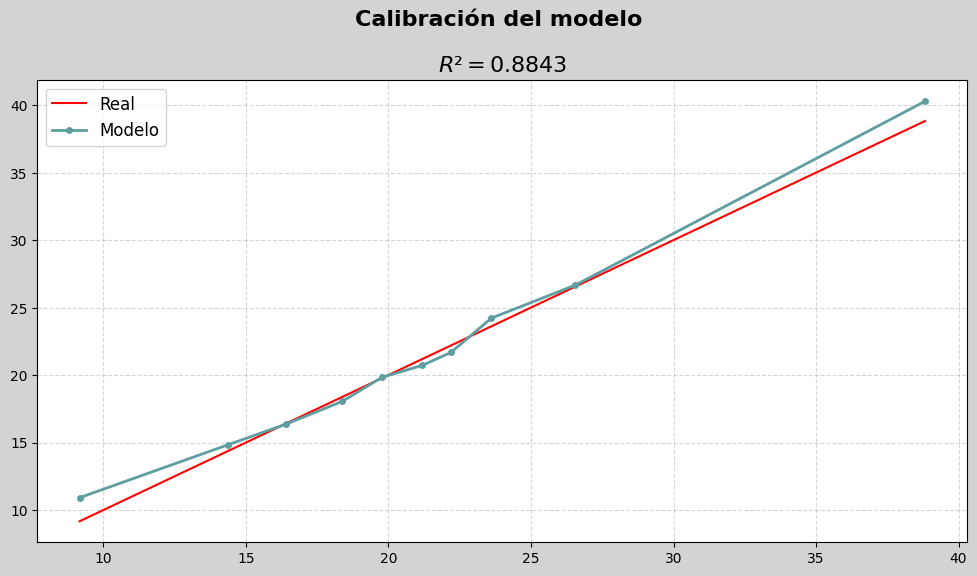

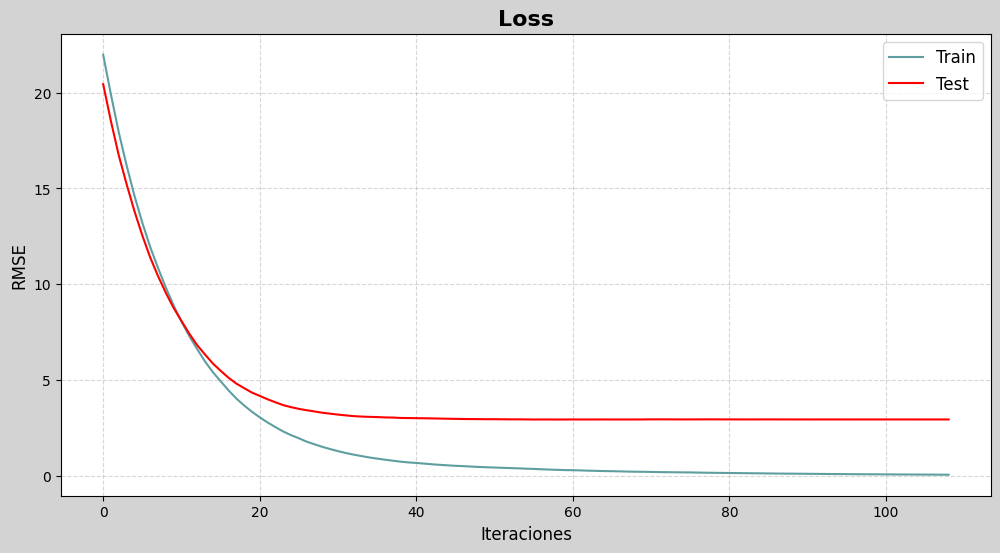

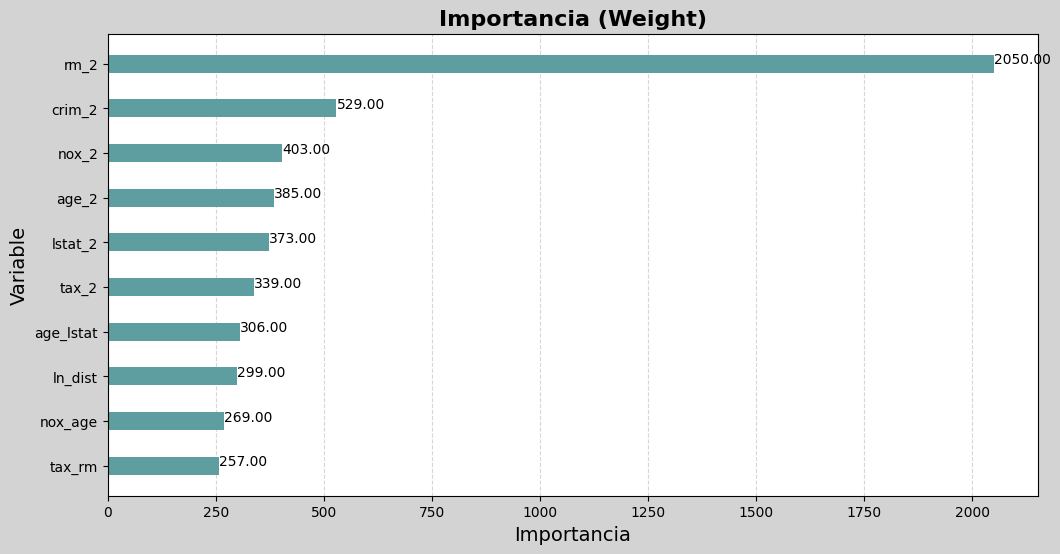

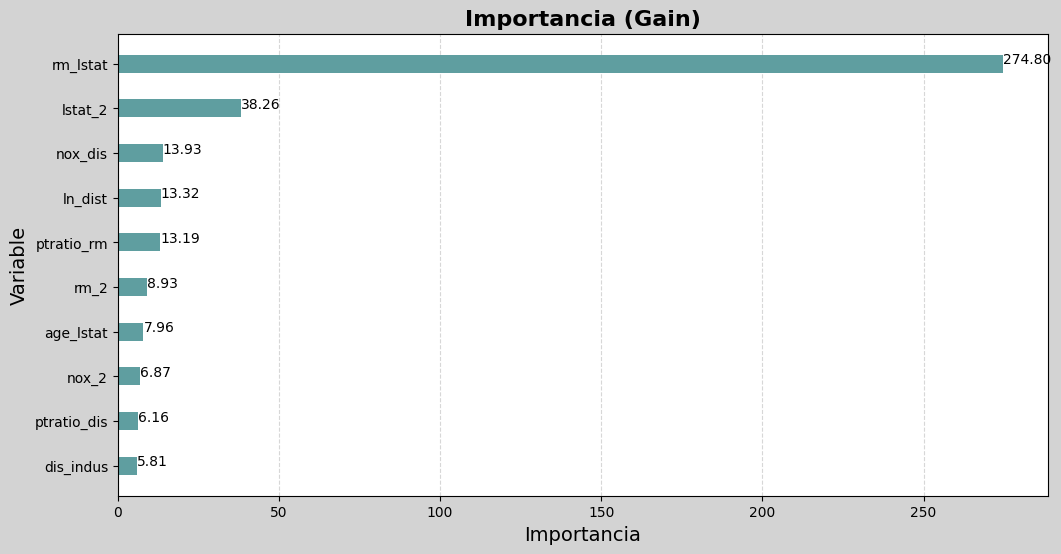

XGBRegressor(base_score=None, booster=None, callbacks=None,
             col_sample_by_tree=0.8, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [11]:
X = df_all_new_not_originals.copy().drop(columns={target})
y = df[target]

xgboost(X, y, 10)

# *Conclusiones*

* El mejor modelo fue XGBoost utilizando las variables originales del dataset logrando un $\text{R}^2$ de 0.9070 y superando por mucho al mejor modelo obtenido en el examen. La variable que más utilizó este modelo fue `crim` con un total de 3.229 veces y la variable que más contribuyó a la reducción del error fue `lstat`.

+ El segundo mejor fue el CatBoost tambien utilizando las variables originales logrando un $\text{R}^2$ de 0.8718. En este modelo se muestran 3 variables que son las que principalmente son las más importantes en el modelo, que son, `rm`, `lstat` y `nox`, las cuales superan el 20% de importancia.

+ El modelo LightGBM fue el peor de todos, utilizando las variables originales se logró un $\text{R}^2$ de 0.8618. En este caso la importancia de las variables no se distribuye en pocas como los modelos anteriores, sino que las variables `lstat`, `rm`, `dis`, `crim` y `age` se utilizaron más de 300 veces, y las que más contribuyeron a la reducción del error son `lstat` y `rm`.

* Como última prueba se realizó un XGBoost con las variables que lograron el mayor R2 con una regresión ridge en el examen parcial 1. Sin embargo, no dio un grán resultado comparado al XGBoost de las variables originales.

+ Luego de probar estos modelos diferentes, concluimos que las variables más importantes son `rm` y `lstat`.

+ XGBoost fue el modelo que logró capturar relaciones más complejas entre las variables originales, lo que explica su alto $\text{R}^2$.